In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import gmsh
import meshio
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
import scipy.interpolate
import scipy.sparse

from femns2d import femns2d

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def create_unit_square_mesh(name="unit_square.msh"):
    gmsh.initialize()
    gmsh.model.add('unit_square')
    
    pfactor = 0.1
    # Create points for unit square corners
    gmsh.model.geo.addPoint(0, -1, 0, pfactor, 1)
    gmsh.model.geo.addPoint(5, -1, 0, pfactor, 2)
    gmsh.model.geo.addPoint(5, 1, 0, pfactor, 3)
    gmsh.model.geo.addPoint(0, 1, 0, pfactor, 4)

    # Connect points with lines to form unit square
    gmsh.model.geo.addLine(1, 2, 1)
    gmsh.model.geo.addLine(2, 3, 2)
    gmsh.model.geo.addLine(3, 4, 3)
    gmsh.model.geo.addLine(4, 1, 4)

    # Create Curve Loop and Plane Surface
    gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
    gmsh.model.geo.addPlaneSurface([1], 1)

    # Add physical lines for the boundaries
    gmsh.model.geo.addPhysicalGroup(1, [1], 1)
    gmsh.model.geo.addPhysicalGroup(1, [2], 2)
    gmsh.model.geo.addPhysicalGroup(1, [3], 3)
    gmsh.model.geo.addPhysicalGroup(1, [4], 4)    
    # Add physical group for the surface
    gmsh.model.geo.addPhysicalGroup(2, [1], 5)

    # Synchronize model and define mesh size
    gmsh.model.geo.synchronize()

    # Generate 2D mesh
    gmsh.model.mesh.generate(2)

    # Save mesh
    gmsh.write('unit_square.msh')

    gmsh.finalize()

In [5]:
create_unit_square_mesh()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000322665s, CPU 0.000281s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0316364s, CPU 0.031965s)
Info    : 1247 nodes 2496 elements
Info    : Writing 'unit_square.msh'...
Info    : Done writing 'unit_square.msh'


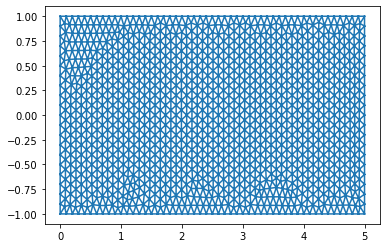

In [6]:
# Read the mesh file
mesh = meshio.read("unit_square.msh")

# Plot the mesh
fig, ax = plt.subplots()
ax.triplot(mesh.points[:, 0], mesh.points[:, 1], mesh.cells_dict["triangle"])

plt.show()

In [7]:
mesh = meshio.read("unit_square.msh")
points = mesh.points
elements = mesh.cells_dict["triangle"]
boundary_elements = mesh.cells_dict["line"]

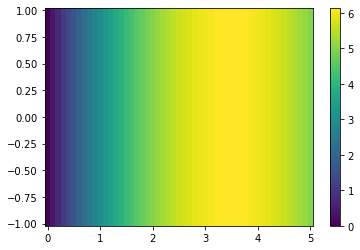

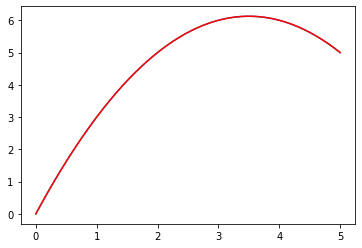

In [8]:
assembler = femns2d.MiniAssembler(mesh)
dirichlet_bcs_p = [[0, 5], [4, 2]]
Kp = assembler.stiffness_matrix()
Kp = assembler.apply_dirichlet_to_matrix(dirichlet_bcs_p[1], Kp, 'u')
fp = assembler.forcing_vector(1.0)
fp = assembler.apply_dirichlet_to_vector(*dirichlet_bcs_p, fp, 'u')
p = scipy.sparse.linalg.spsolve(Kp.tocsc(), fp)
p_interp = scipy.interpolate.LinearNDInterpolator(assembler.pointse[:, :-1], p)
X, Y = np.meshgrid(np.linspace(0, 5, 51), np.linspace(-1, 1, 51))
P = p_interp(X, Y)
plt.figure()
plt.pcolormesh(X, Y, P, shading='auto')
plt.colorbar()
plt.figure()
n = 50
y = np.zeros(n)
x = np.linspace(0, 5, n)
p = p_interp(x, y)
plt.plot(x, p)
plt.plot(x, -1/2*x**2 + (5 + 25/2)/5*x, 'r')

In [9]:
# dirichlet_bcs_u = [[0, 0], [1, 3]]
# dirichlet_bcs_v = [[0, 0], [1, 3]]
# dirichlet_bcs_p = [[5, 0], [4, 2]]
for step in range(10):
    assembler = femns2d.MiniAssembler(mesh)
    Re = 1.0
    ex = np.array([1.0, 0.0])
    ey = np.array([0.0, 1.0])
    K = assembler.stiffness_matrix(1/Re)
    Azero = scipy.sparse.dok_matrix((assembler.npointse, assembler.npointse))
    Azerop = scipy.sparse.dok_matrix((assembler.npoints, assembler.npoints))
    Guxp = assembler.velocity_pressure_convection_matrix(ex)
    Guyp = assembler.velocity_pressure_convection_matrix(ey)
    Gpux = Guxp.T
    Gpuy = Guyp.T
    if step == 0: #Initial solution, Stokes in practice
        Ginertia = scipy.sparse.dok_matrix((assembler.npointse, assembler.npointse))
    else:
        ue = assembler.get_element_velocities(uxyp)
        Ginertia = assembler.convection_matrix(lambda i :ue[i], velocity_fn_type='element')
    KG = K + Ginertia
    Au = scipy.sparse.bmat([[KG, Azero, Guxp]])
    Av = scipy.sparse.bmat([[Azero, KG, Guyp]])
    Ap = scipy.sparse.bmat([[Gpux, Gpuy, Azerop]])
    A = scipy.sparse.bmat([[Au], [Av], [Ap]])
    A = scipy.sparse.dok_matrix(A)
    u_bc_func = lambda x : 1-(x[..., 1]**2)
    dirichlet_bcs_u = [[u_bc_func, u_bc_func, 0, 0], [4, 2, 1, 3]]
    dirichlet_bcs_v = [[0, 0, 0, 0], [4, 2, 1, 3]]
    dirichlet_bcs_p = [[0.0], [2]]

    A = assembler.apply_dirichlet_to_matrix(dirichlet_bcs_p[1], A, 'p')
    A = assembler.apply_dirichlet_to_matrix(dirichlet_bcs_u[1], A, 'u')
    A = assembler.apply_dirichlet_to_matrix(dirichlet_bcs_v[1], A, 'v')
    A_sparse = A.tocsc()

    f = np.hstack([assembler.forcing_vector(0.0),
                   assembler.forcing_vector(0.0),
                   assembler.forcing_vector(0.0)[:assembler.npoints]])

    f = assembler.apply_dirichlet_to_vector(*dirichlet_bcs_p, f, 'p')
    f = assembler.apply_dirichlet_to_vector(*dirichlet_bcs_u, f, 'u')
    f = assembler.apply_dirichlet_to_vector(*dirichlet_bcs_v, f, 'v')
    uxyp_new = scipy.sparse.linalg.spsolve(A_sparse, f)
    if step == 0:
        uxyp = uxyp_new.copy()
    else:
        duxyp = uxyp_new - uxyp
        error = np.max(np.abs(duxyp))
        uxyp = uxyp_new.copy()
        print(step, error)

1 0.00044501878534397576


KeyboardInterrupt: 

In [10]:
#Gx = b -> $G(dx) = b + Gx

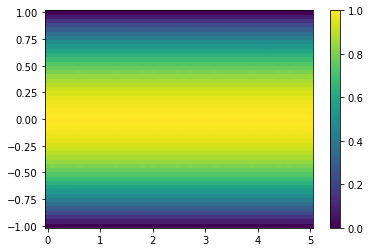

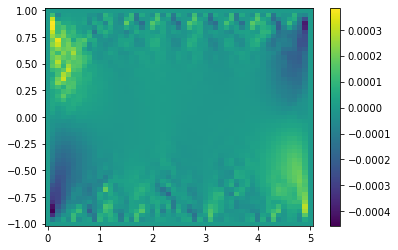

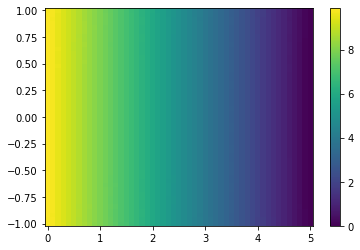

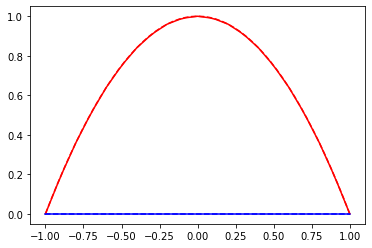

In [12]:
ux, uy, p = assembler.split_velocities(uxyp)
ux_interp = scipy.interpolate.LinearNDInterpolator(assembler.pointse[:, :-1], ux)
uy_interp = scipy.interpolate.LinearNDInterpolator(assembler.pointse[:, :-1], uy)
p_interp = scipy.interpolate.LinearNDInterpolator(assembler.points[:, :-1], p)

X, Y = np.meshgrid(np.linspace(0, 5, 51), np.linspace(-1, 1, 51))
UX = ux_interp(X, Y)
UY = uy_interp(X, Y)
P = p_interp(X, Y)
for Z in [UX, UY, P]:
    plt.figure()
    plt.pcolormesh(X, Y, Z, shading='auto')
    plt.colorbar()

n = 51
x = np.ones(n)*5.0
y = np.linspace(-1, 1, n)
ux = ux_interp(x, y)
uy = uy_interp(x, y)

plt.figure()
plt.plot(y, ux, 'r')
plt.plot(y, uy, 'b')
plt.plot(y, 1.0*(1-y**2), 'r--')
plt.plot(y, 0.0*y, 'b--')